In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from typing import Callable, Dict, Tuple, Optional, Union
import autograd 
from autograd import grad, jacobian
import warnings
warnings.filterwarnings('ignore')

class RobustQLEVolatilityModel:
    
    
    def __init__(self, alpha_loss: float = None, c: float = None):
        
        self.alpha_loss = alpha_loss
        self.c = c
        self.params = None
        self.param_names = ['omega', 'gamma', 'beta']
        if alpha_loss is None:
            self.param_names.append('alpha_loss')
        if c is None:
            self.param_names.append('c')
        self.fitted_volatility = None
        self.residuals = None
    
    def _rho_derivative(self, e: np.ndarray, alpha: float, c: float) -> np.ndarray:
        
        # Handle scalar inputs by converting to numpy arrays
        if np.isscalar(e):
            e = np.array([e])
            scalar_input = True
        else:
            scalar_input = False
            
        if alpha == 2:
            # L2 loss (least squares)
            result = e / (c**2)
        elif alpha == 0:
            # Cauchy/Lorentzian loss
            result = (2 * e) / (e**2 + 2 * c**2)
        elif alpha == float('-inf'):
            # Welsch/Leclerc loss
            result = (e / c**2) * np.exp(-0.5 * (e/c)**2)
        else:
            # General case
            result = (e / c**2) * np.power((e**2 / c**2) / np.abs(alpha-2) + 1, alpha/2 - 1)
        
        # Return scalar if input was scalar
        if scalar_input:
            return result[0]
        return result
    
    #def _rho_second_derivative(self, e: np.ndarray, alpha: float, c: float) -> np.ndarray:
        
        # Handle scalar inputs by converting to numpy arrays
        if np.isscalar(e):
            e = np.array([e])
            scalar_input = True
        else:
            scalar_input = False
            
        if alpha == 2:
            # L2 loss (least squares)
            result = np.ones_like(e) / (c**2)
        elif alpha == 0:
            # Cauchy/Lorentzian loss
            denom = (1 + 0.5 * (e/c)**2)**2
            result = (1 / c**2) * (1 - 0.5 * (e/c)**2) / denom
        elif alpha == float('-inf'):
            # Welsch/Leclerc loss
            result = (1 / c**2) * (1 - (e**2 / c**2)) * np.exp(-0.5 * (e/c)**2)
        else:
            # General case
            base_term = np.power((e/c)**2 / np.abs(alpha-2) + 1, alpha/2 - 2)
            part1 = (1 / c**2) * base_term
            part2 = (e/c)**2 / np.abs(alpha-2) + 1
            part3 = part2 + (alpha/2 - 1) * (2 * e**2) / (c**2 * np.abs(alpha-2))
            result = part1 * part3
            
        
        # Return scalar if input was scalar
        if scalar_input:
            return result[0]
        return result
    def _rho_second_derivative(self, e: np.ndarray, alpha: float, c: float) -> np.ndarray:
        
        # Handle scalar inputs by converting to numpy arrays
        if np.isscalar(e):
            e = np.array([e])
            scalar_input = True
        else:
            scalar_input = False
            
        if alpha == 2:
            # L2 loss (least squares)
            result = -np.ones_like(e) / (c**2)
        elif alpha == 0:
            # Cauchy/Lorentzian loss
            denom = (e**2 + 2 * c**2)**2
            result = -(2*(e**2 + 2* c**2) - 4 * e **2) / denom
        elif alpha == float('-inf'):
            # Welsch/Leclerc loss
            first_term = ((e)**2 * np.exp( -((e**2)/(2* (c**2)))))/(c**4)
            second_term = np.exp( -((e**2)/(2* (c**2))))/(c**2)
            result = (first_term - second_term)
        else:
            # General case
            e2 = (e)**2
            denom = c**2 * np.abs(alpha - 2)
            A = e2 / denom + 1

            term1 = -2 * (alpha/2 - 1) * A**(alpha/2 - 2) * e2
            term1 /= (c**4 * np.abs(alpha - 2))

            term2 = - A**(alpha/2 - 1) / (c**2)

            return term1 + term2
            
        
        # Return scalar if input was scalar
        if scalar_input:
            return result[0]
        return result
    
    #def dpsi_dalpha(self, e_t, c, alpha_loss):
        
        # define a small neighborhood around the problematic points:
        eps = 1e-4

        # if α is within ±eps of 2, treat it as exactly 2 (L2 case)
        if abs(alpha_loss - 2) < eps:
            delta = 1e-5
            psi_plus = self._rho_derivative(e_t, alpha_loss + delta, self.c) 
            psi_minus = self._rho_derivative(e_t, alpha_loss - delta, self.c) 
            dpsi_dalpha = (psi_plus - psi_minus) / (2 * delta)
            return dpsi_dalpha  # ∂ψ/∂α = 0 for the L2 loss

        # similarly guard α≈0
        if abs(alpha_loss - 0) < eps:
            # use the closed-form ∂ψ/∂α at α=0 (which you've already set to 0)
            delta = 1e-5
            psi_plus = self._rho_derivative(e_t, alpha_loss + delta, self.c) 
            psi_minus = self._rho_derivative(e_t, alpha_loss - delta, self.c)
            dpsi_dalpha = (psi_plus - psi_minus) / (2 * delta)
            return dpsi_dalpha

        # if you ever parameterize "α = −∞" as, say, alpha_loss < some negative cutoff
        if alpha_loss < -1e3:
            delta = 1e-5
            psi_plus = self._rho_derivative(e_t, alpha_loss + delta, self.c) 
            psi_minus = self._rho_derivative(e_t, alpha_loss - delta, self.c) 
            dpsi_dalpha = (psi_plus - psi_minus) / (2 * delta)
            return dpsi_dalpha  

        # otherwise you're safely away from the singularities, so use your general formula:
        abs_alpha_minus_2 = np.abs(alpha_loss - 2)
        denominator_inner = c**2 * abs_alpha_minus_2
        inner_term = (e_t**2) / denominator_inner + 1
        power_term = inner_term**(alpha_loss / 2 - 1)

        log_term = np.log(inner_term) / 2
        frac_term = (e_t**2 * (alpha_loss / 2 - 1)) / (
            c**2 * inner_term * abs_alpha_minus_2 * (alpha_loss - 2)
        )

        numerator = e_t * power_term * (log_term - frac_term)

        return (numerator / c**2)
    def dpsi_dalpha(self, e_t, c, alpha_loss):
        
        # define a small neighborhood around the problematic points:
        eps = 1e-4

        # if α is within ±eps of 2, treat it as exactly 2 (L2 case)
        if abs(alpha_loss - 2) < eps:
            delta = 1e-5
            psi_plus = self._rho_derivative(e_t, alpha_loss + delta, self.c) 
            psi_minus = self._rho_derivative(e_t, alpha_loss - delta, self.c) 
            dpsi_dalpha = (psi_plus - psi_minus) / (2 * delta)
            return dpsi_dalpha  # ∂ψ/∂α = 0 for the L2 loss

        # similarly guard α≈0
        if abs(alpha_loss - 0) < eps:
            # use the closed-form ∂ψ/∂α at α=0 (which you've already set to 0)
            delta = 1e-5
            psi_plus = self._rho_derivative(e_t, alpha_loss + delta, self.c) 
            psi_minus = self._rho_derivative(e_t, alpha_loss - delta, self.c) 
            dpsi_dalpha = (psi_plus - psi_minus) / (2 * delta)
            return dpsi_dalpha

        # if you ever parameterize "α = −∞" as, say, alpha_loss < some negative cutoff
        if alpha_loss < -1e3:
            delta = 1e-5
            psi_plus = self._rho_derivative(e_t, alpha_loss + delta, self.c) 
            psi_minus = self._rho_derivative(e_t, alpha_loss - delta, self.c)
            dpsi_dalpha = (psi_plus - psi_minus) / (2 * delta)
            return dpsi_dalpha  

        # otherwise you're safely away from the singularities, so use your general formula:
        alpha= alpha_loss
        e2 = e_t**2
        denom = c**2 * np.abs(alpha - 2)
        A = (e2 / denom) + 1

        # Compute the bracket term
        term_log = np.log(A) / 2
        term_frac = (e2 * (alpha/2 - 1)) / (c**2 * A * np.abs(alpha - 2) * (alpha - 2))
        bracket = term_log - term_frac

        # Combine everything
        result = (e_t * A**(alpha/2 - 1) * bracket) / (c**2)
        return result

    
    #def dpsi_dc(self, e_t, c, alpha_loss):
       
        eps = 1e-4

        if alpha_loss == 2:
            # dψ/dc = -2e / c³
            return -2 * e_t / c**3

        elif abs(alpha_loss) < eps:
            # dψ/dc = -8ec / (e² + 2c²)²
            return -8 * e_t * c / (e_t**2 + 2 * c**2)**2

        elif alpha_loss < -1e3:
            # dψ/dc = ( -2e / c³ + e³ / c⁵ ) * exp(-½ (e/c)²)
            z = e_t / c
            exp_term = np.exp(-0.5 * z**2)
            return (-2 * e_t / c**3 + e_t**3 / c**5) * exp_term

        else:
            # General case:
            # dψ/dc = [ -2e / c³ 
            #           + (e / c²)(α/2 - 1)( (e² / (c²|α−2|) + 1 )**(α/2 - 2) ) * (-2e² / (c³|α−2|)) ]
            #         * (e² / (c²|α−2|) + 1 )**(α/2 - 1)
            abs_alpha_diff = np.abs(alpha_loss - 2)
            z_sq = (e_t**2) / (c**2 * abs_alpha_diff)
            base = z_sq + 1
            power1 = (alpha_loss / 2) - 2
            power2 = (alpha_loss / 2) - 1

            first_term = -2 * e_t / c**3
            second_term = (e_t / c**2) * ((alpha_loss / 2) - 1) * (base**power1) * (-2 * e_t**2 / (c**3 * abs_alpha_diff))

            return (first_term + second_term) * base**power2
    def dpsi_dc(self, e_t, c, alpha_loss):
       
        eps = 1e-4

        if alpha_loss == 2:
            # dψ/dc = -2e / c³
            return -2 * e_t / c**3

        elif abs(alpha_loss) < eps:
            # dψ/dc = -8ec / (e² + 2c²)²
            return -8 * e_t * c / (e_t**2 + 2 * c**2)**2

        elif alpha_loss < -1e3:
            # dψ/dc = ( -2e / c³ + e³ / c⁵ ) * exp(-½ (e/c)²)
            z = e_t / c
            exp_term = np.exp(-0.5 * z**2)
            return (-2 * e_t / c**3 + e_t**3 / c**5) * exp_term

        else:
            alpha = alpha_loss
            e2 = e_t**2
            denom = np.abs(alpha - 2) * c**2
            A = e2 / denom + 1

            term1 = -2 * e_t * A**(alpha/2 - 1) / (c**3)
            term2 = -2 * e_t**3 * (alpha/2 - 1) * A**(alpha/2 - 2) / (np.abs(alpha - 2) * c**5)
            
            return term1 + term2
            # General case:
            
    
    def _filter_volatility(self, y: np.ndarray, params: np.ndarray) -> np.ndarray:
        
        T = len(y)
        omega, gamma, beta = params[:3]
        
        param_idx = 3
        
        # Get alpha_loss parameter
        if self.alpha_loss is None:
            alpha_loss = params[param_idx]
            param_idx += 1
        else:
            alpha_loss = self.alpha_loss
        
        # Get c parameter
        if self.c is None:
            c = params[param_idx]
        else:
            c = self.c
        
        # Initialize volatility with the unconditional variance
        f = np.zeros(T+1)
        f[0] = omega/(1-beta)
        
        # Recursively update the volatility
        for t in range(T):
            e_t = y[t]**2 - f[t]
            psi_t = self._rho_derivative(e_t, alpha_loss, c)   
            f[t+1] = omega + gamma * psi_t + beta * f[t]
            
            # Enforce positive volatility
            f[t+1] = max(f[t+1], 1e-12)
        
        return f[1:]
    
    def _compute_derivatives(self, y: np.ndarray, f: np.ndarray, params: np.ndarray) -> np.ndarray:
       
        T = len(y)
        omega, gamma, beta = params[:3]
        
        param_idx = 3
        n_params = 3
        
        # Get alpha_loss parameter
        if self.alpha_loss is None:
            alpha_loss = params[param_idx]
            param_idx += 1
            n_params += 1
        else:
            alpha_loss = self.alpha_loss
        
        # Get c parameter
        if self.c is None:
            c = params[param_idx]
            n_params += 1
        else:
            c = self.c
        
        # Initialize derivatives of f_t with respect to theta
        e0 = y[0]**2 - f[0]
        psi0 =  self._rho_derivative(e0, alpha_loss, c)
        d2psi0_df = self._rho_second_derivative(e0, alpha_loss, c) 
        df_dtheta = np.zeros((T, n_params))
        df_dtheta[0, 0] = 1                  # ∂f₁/∂ω
        df_dtheta[0, 1] = psi0               # ∂f₁/∂γ
        df_dtheta[0, 2] = f[0]               # ∂f₁/∂β
        
        # Initialize derivatives for alpha_loss and c if they are estimated
        param_idx = 3
        
        if self.alpha_loss is None:
            dpsi0_dalpha = self.dpsi_dalpha(e0, c, alpha_loss)
            df_dtheta[0, param_idx] = gamma * dpsi0_dalpha  # ∂f₁/∂α
            param_idx += 1
        
        if self.c is None:
            dpsi0_dc = self.dpsi_dc(e0, c, alpha_loss)
            df_dtheta[0, param_idx] = gamma * dpsi0_dc  # ∂f₁/∂c
    
        # According to the recursive formula:
        
        for t in range(1, T):
            e_t = (y[t-1]**2 - f[t-1])
            psi_t = self._rho_derivative(e_t, alpha_loss, c)  
            d2psi_df = self._rho_second_derivative(e_t, alpha_loss, c)   
            
            # Common term in recursive updates
            common_term = gamma * d2psi_df + beta
            
            # Derivative with respect to parameters
            # For omega (∂ω/∂θ_0 = 1, else 0)
            df_dtheta[t, 0] = 1 + df_dtheta[t-1, 0] * common_term
            
            # For gamma (∂γ/∂θ_1 = 1, else 0)
            df_dtheta[t, 1] = psi_t + df_dtheta[t-1, 1] * common_term
            
            # For beta (∂β/∂θ_2 = 1, else 0)
            df_dtheta[t, 2] = f[t-1] + df_dtheta[t-1, 2] * common_term
            
            # Reset param_idx for additional parameters
            param_idx = 3
            
            # Derivative with respect to alpha_loss, if applicable
            if self.alpha_loss is None:
                dpsi_dalpha = self.dpsi_dalpha(e_t, c, alpha_loss)
                df_dtheta[t, param_idx] = gamma * dpsi_dalpha + common_term * df_dtheta[t-1, param_idx]
                param_idx += 1
            
            # Derivative with respect to c, if applicable
            if self.c is None:
                dpsi_dc = self.dpsi_dc(e_t, c, alpha_loss)
                df_dtheta[t, param_idx] = gamma * dpsi_dc + common_term * df_dtheta[t-1, param_idx]
        
        return df_dtheta
    
    def _qle_objective(self, params: np.ndarray, y: np.ndarray) -> float:
        
        try:
            # Apply parameter constraints
            param_idx = 3
            
            if self.alpha_loss is None:
                # Ensure alpha_loss is in reasonable range
                if params[param_idx] < -10 or params[param_idx] > 10:
                    return 1e10
                param_idx += 1
            
            if self.c is None:
                # Ensure c is positive and reasonable
                if params[param_idx] <= 0 or params[param_idx] > 10:
                    return 1e10
            
            # Basic parameter constraints for volatility model stability
            if params[0] <= 0 or params[1] < 0 or params[2] < 0 or params[2] >= 1 or params[1] + params[2] >= 0.999:
                return 1e10
            
            # Filter volatility
            f = self._filter_volatility(y, params)
            
            # Compute residuals - h_t is defined as y_t^k - f_t(θ)
            h_t = y**2 - f
            
            # Use f as the conditional variance approximation
            sigma2_t = f
            
            # Compute derivatives of f_t with respect to parameters
            df_dtheta = self._compute_derivatives(y, f, params)
            
            # G_t(θ) = (1/T) * sum[ h_t(θ) / σ²_t(θ) * ∂f_t(θ)/∂θ ]
            G_t = np.sum(h_t.reshape(-1, 1) / sigma2_t.reshape(-1, 1) * df_dtheta, axis=0) / len(y)
            
            # The objective is to minimize ||G_t(θ)||²
            obj = np.linalg.norm(G_t)
            
            return obj
        except Exception as e:
            print(f"Error in objective function: {e}")
            return 1e10
    
    def fit(self, y: np.ndarray, initial_params: Optional[Dict] = None, 
            method: str = 'Nelder-Mead', maxiter: int = 2000) -> Dict:
        
        # Set default initial parameters if not provided
        if initial_params is None:
            initial_params = {
                'omega': 0.07, 
                'gamma': 0.11, 
                'beta': 0.8
            }
            if self.alpha_loss is None:
                initial_params['alpha_loss'] = 1  # Default value close to Cauchy loss
            
            if self.c is None:
                initial_params['c'] = 1.2  # Default value for scale parameter
        
        # Prepare initial parameter array
        init_params = np.array([initial_params[name] for name in self.param_names])
        
        # Run optimization
        options = {'maxiter': maxiter, 'disp': True}
        
        # Different optimization methods may work better in different cases
        if method == 'Nelder-Mead':
            options['adaptive'] = True  # Use adaptive Nelder-Mead for better convergence
            result = minimize(
                self._qle_objective, 
                init_params, 
                args=(y,), 
                method=method, 
                options=options,
            )
        elif method == 'BFGS':
            options = {'maxiter': maxiter, 'gtol': 1e-6}
            result = minimize(
                self._qle_objective, 
                init_params, 
                args=(y,), 
                method=method, 
                options=options,
            )
        elif method == 'differential_evolution':
            # Set up bounds for differential evolution
            bounds = []
            
            # Basic parameters bounds
            bounds.extend([(0.001, 0.5), (0.001, 0.5), (0.6, 0.999)])
            
            # Alpha bounds if estimated
            if self.alpha_loss is None:
                bounds.append((-5, 5))
            
            # c bounds if estimated
            if self.c is None:
                bounds.append((0.1, 5.0))
            
            result = differential_evolution(
                self._qle_objective,
                bounds=bounds,
                args=(y,),
                strategy='best1bin',
                maxiter=maxiter,
                disp=True,
                polish=True
            )
        
        if not result.success and method != 'differential_evolution':
            print(f"Warning: Optimization did not converge: {result.message}")
            
            # Try again with different method if first one failed
            if method == 'Nelder-Mead':
                print("Trying BFGS method instead...")
                result = minimize(
                    self._qle_objective,
                    init_params,
                    args=(y,),
                    method='BFGS',
                    options={'maxiter': maxiter}
                )
        
        # Store parameters
        self.params = {name: val for name, val in zip(self.param_names, result.x)}
        
        # Compute fitted volatility
        param_array = np.array([self.params[name] for name in self.param_names])
        self.fitted_volatility = self._filter_volatility(y, param_array)
        self.residuals = y**2 - self.fitted_volatility
        
        print(f"Optimization result: {result.message}")
        print(f"Parameters: {self.params}")
        
        return self.params
    
    
    
    def plot_volatility(self, y: np.ndarray, true_vol: np.ndarray = None, title: str = "Estimated Volatility") -> None:
        
        if self.fitted_volatility is None:
            raise ValueError("Model must be fit before plotting")
        
        plt.figure(figsize=(12, 8))
        
        # Plot original data
        plt.subplot(2, 1, 1)
        plt.plot(y, 'b-', alpha=0.5, label='Returns')
        plt.title(title)
        plt.legend()
        
        # Plot volatility
        plt.subplot(2, 1, 2)
        plt.plot(np.sqrt(self.fitted_volatility), 'r-', label='Estimated Volatility')
        
        if true_vol is not None:
            plt.plot(np.sqrt(true_vol), 'b-', alpha=0.3, label='True Volatility')
        
        plt.legend()
        plt.ylim(0, np.max(np.sqrt(self.fitted_volatility)) * 1.5)
        plt.tight_layout()
        plt.show()
    
    def simulate(self, T: int, dist: str = 't', df: int = 5, seed: int = None) -> Tuple[np.ndarray, np.ndarray]:
        
        if self.params is None:
            raise ValueError("Parameters must be set before simulation")
        
        if seed is not None:
            np.random.seed(seed)
        
        omega = self.params['omega']
        gamma = self.params['gamma']
        beta = self.params['beta']
        
        if self.alpha_loss is None:
            alpha_loss = self.params['alpha_loss']
        else:
            alpha_loss = self.alpha_loss
        
        if self.c is None:
            c = self.params['c']
        else:
            c = self.c
        
        # Initialize arrays
        y = np.zeros(T)
        f = np.zeros(T+1)
        f[0] = omega / (1 - beta)  # Start at unconditional variance
        
        # Generate innovations
        if dist == 't':
            eps = np.random.standard_t(df, T)
        else:
            eps = np.random.normal(0, 1, T)
            
        # Generate data
        for t in range(T):
            # Generate return
            y[t] = np.sqrt(f[t]) * eps[t]
            
            # Compute the score
            e_t = (y[t]**2 - f[t])
            psi_t = self._rho_derivative(e_t, alpha_loss, c) 
            
            # Update volatility
            f[t+1] = omega + gamma * psi_t + beta * f[t]
            #f[t+1] = max(f[t+1], 1e-12)  # Ensure positive volatility
            
        return y, f[1:]

# Estimating

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from typing import Callable, Dict, Tuple, Optional, Union
import autograd 
from autograd import grad, jacobian
import warnings
warnings.filterwarnings('ignore')


"""Demonstrate the model's performance with outliers in the data"""
# Set parameters for the data generating process
true_params = {
    'omega': 0.07,
    'gamma': 0.11,
    'beta': 0.80,
    'alpha_loss': 1,
    'c': 1.2
}

# Create a model with the true parameters for simulation
sim_model = RobustQLEVolatilityModel(alpha_loss=true_params['alpha_loss'])
sim_model.params = true_params

# Simulate clean data
T = 15000
y_clean, true_vol = sim_model.simulate(T, dist='n', df=7, seed=42)

# Create a copy of the data with outliers
y_outliers = y_clean.copy()

# Add outliers at different positions and with different magnitudes

# 1. Add a few isolated very large outliers
np.random.seed(123)
outlier_positions = np.random.choice(range(500, T-500), 10, replace=False)
outlier_signs = np.random.choice([-1, 1], 10)

for i, pos in enumerate(outlier_positions):
    # Create outliers that are 10-15 standard deviations from the mean
    local_std = np.sqrt(true_vol[pos])
    y_outliers[pos] = outlier_signs[i] * np.random.uniform(10, 15) * local_std

# 2. Add a cluster of moderately large outliers (simulating a volatility burst)
cluster_start = 3000
for i in range(30):
    local_std = np.sqrt(true_vol[cluster_start + i])
    if i % 2 == 0:  # every other observation is an outlier
        y_outliers[cluster_start + i] = np.random.choice([-1, 1]) * np.random.uniform(5, 8) * local_std



# Create models for comparison
# L2 loss model (standard QLE, not robust)
model_l2 = RobustQLEVolatilityModel(alpha_loss=2)

model_alpha1_5 = RobustQLEVolatilityModel(alpha_loss=1.5)

# Cauchy loss model (should be robust)
model_cauchy = RobustQLEVolatilityModel(alpha_loss=0)

# Alpha=1 model (should be robust)
model_alpha1 = RobustQLEVolatilityModel(alpha_loss=1)

# Model with estimated alpha
model_est = RobustQLEVolatilityModel()

# Fit the models to the data with outliers
print("\nFitting standard QLE model (alpha=2):")
params_l2 = model_l2.fit(y_outliers, method='Nelder-Mead')

params_alpha1_5 = model_alpha1_5.fit(y_outliers, method='Nelder-Mead')

print("\nFitting robust model with Cauchy loss (alpha=0):")
params_cauchy = model_cauchy.fit(y_outliers, method='Nelder-Mead')

print("\nFitting robust model with alpha=1:")
params_alpha1 = model_alpha1.fit(y_outliers, method='Nelder-Mead')

print("\nFitting model with estimated alpha:")
params_est = model_est.fit(y_outliers, method='Nelder-Mead')



Fitting standard QLE model (alpha=2):
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 302
         Function evaluations: 531
Optimization result: Optimization terminated successfully.
Parameters: {'omega': np.float64(0.035557755805961), 'gamma': np.float64(0.0928373280499677), 'beta': np.float64(0.8842889424706641), 'c': np.float64(1.4890550579525963)}
Optimization terminated successfully.
         Current function value: 0.002476
         Iterations: 414
         Function evaluations: 692
Optimization result: Optimization terminated successfully.
Parameters: {'omega': np.float64(0.12412628235944707), 'gamma': np.float64(0.15546422012949107), 'beta': np.float64(0.39889700838960596), 'c': np.float64(0.5983754761347673)}

Fitting robust model with Cauchy loss (alpha=0):
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 1165
         Function evaluations: 1948
Optimization result: Opti

In [9]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.special import gammaln

class Beta_t_GARCH11:
    def __init__(self, y):
        """
        β_t GARCH(1,1) with Student‐t innovations:
        
        y_t = sqrt(f_t) * ε_t,   ε_t ~ t_ν   (ν > 2)
        
        Recursion:
             ε_t = y_t / sqrt(f_t)
             f_{t+1} = ω 
                        + α * [ (ν + 1) * ε_t^2 / (ν - 2 + ε_t^2 ) ] 
                        + β * f_t
        
        The log‐likelihood at time t (for y_t | f_t) is that of a 
        Student‐t with ν degrees of freedom, zero mean, and scale = sqrt(f_t).
        """
        self.y = np.asarray(y, dtype=float)
        self.T = len(self.y)


    def _compute_nll_and_variances(self, params):
        """
        Given params = [omega, alpha, beta], construct {f_t}_{t=0..T-1} in‐sample 
        and return (negative log‐likelihood, the array f).
        """
        ω, α, β, ν = params

        
        # If any basic constraints are violated, return a large penalty
        if ω <= 0 or α < 0 or β < 0 or α + β >= 1:
            return 1e10, None
        
        # Container for f_t
        f = np.zeros(self.T)
        nll = 0.0
        
        # Initialize f[0] at the sample variance of y (to avoid zero)
        sample_var = np.var(self.y)
        f[0] = sample_var + 1e-8
        
        # Precompute constants for the Student‐t density:
        #   const_part = Γ((ν+1)/2) - Γ(ν/2) - 0.5*log[π (ν - 2)]
        const_part = (
            gammaln( (ν + 1.0) / 2.0 ) 
            - gammaln( ν / 2.0 ) 
            - 0.5 * np.log( np.pi * (ν - 2.0) )
        )
        
        for t in range(self.T - 1):
            yt = self.y[t]
            ft = f[t]
            
            # Standardized residual ε_t
            eps_t = yt / np.sqrt(ft)
            
            # Student‐t log‐density at time t:
            #   log p(y_t | f_t) 
            #   = const_part 
            #     - 0.5 * log(f_t) 
            #     - ((ν + 1)/2) * log[ 1 + (y_t^2) / ((ν - 2) f_t) ].
            logpdf_t = (
                const_part 
                - 0.5 * np.log(ft)
                - ((ν + 1.0) / 2.0) 
                  * np.log( 1.0 + (yt * yt) / ((ν - 2.0) * ft) )
            )


            nll -= logpdf_t  # accumulate negative log‐likelihood
            
            # Now update f[t+1]:
            #   f[t+1] = ω + α * [ (ν + 1) * ε_t^2 / (ν - 2 + ε_t^2) ] + β * f_t
            numerator   = (ν + 1.0) * (eps_t * eps_t)
            denominator = (ν - 2.0) + (eps_t * eps_t)
            score_factor = numerator / denominator 
            f[t + 1] = ω + α * score_factor * ft + β * ft
            
            # ensure positivity (numerical safeguard)
            if f[t + 1] <= 0:
                return 1e10, None
        
        # We also need to include the log‐likelihood contribution at t = T-1 (last point):
        y_last = self.y[-1]
        f_last = f[-1]
        eps_last = y_last / np.sqrt(f_last)
        logpdf_last = (
            const_part 
            - 0.5 * np.log(f_last)
            - ((ν + 1.0) / 2.0) 
              * np.log( 1.0 + (y_last * y_last) / ((ν - 2.0) * f_last) )
        )
        nll -= logpdf_last
        
        return nll, f
    def fit(self):
        """
        Estimate (ω, α, β) by minimizing the negative log‐likelihood.
        We impose:
          • ω > 0,
          • α ≥ 0,
          • β ≥ 0,
          • α + β < 1   (weak stationarity).
        """
        # Initial guess: set ω ≈ 0.1 × Var(y), α = 0.05, β = 0.9
        sample_var = np.var(self.y)
        init_params = np.array([0.07, 0.11, 0.8,6.0])  # [ω, α, β, ν]
        
        # Box‐bounds: ω ∈ (1e-8, ∞), α ∈ [0, 1), β ∈ [0, 1)
        bounds = [
            (1e-8, None),   # ω > 0
            (0.0, 0.9999),  # 0 ≤ α < 1
            (0.0, 0.9999) , 
              (2, 100)  # 0 ≤ β < 1
        ]
        
        def objective(p):
            nll, _ = self._compute_nll_and_variances(p)
            return nll
        
        #result = minimize(
            objective,
            init_params,
            method='Nelder-mead',
            bounds=bounds,
            options={'disp': False, 'maxiter': 1000}
        #)

        result = minimize(
            objective,
            init_params,
            method='L-BFGS-B',
            bounds=bounds,
            options={'disp': False, 'maxiter': 1000}
        )
        
        self.params = result.x
        _, self.fitted_f = self._compute_nll_and_variances(self.params)
        return result

    def get_fitted_variances(self):
        """
        After fitting, returns the in‐sample sequence {f_t}.
        """
        return self.fitted_f





class GAS_Model:
    """
    GAS(1,1) equivalent to GARCH(1,1) under Normal assumption. This model is a volatility model.
    """
    def __init__(self, y):
        """
        GAS(1,1) equivalent to GARCH(1,1) under Normal assumption:
        link=f_identity (f_t = sigma2_t), scaling=identity
        Model: f_{t+1} = omega + alpha * y_t^2 + beta * f_t
        where f_t = sigma2_t.
        """
        self.y = np.asarray(y)
        self.T = len(y)

    def _update_f(self, params):
        omega, alpha, beta = params
        f = np.zeros(self.T)
        ll = 0.0
        # initialize f[0] at sample variance
        f[0] = np.var(self.y)
        for t in range(1, self.T):
            # conditional variance update (GAS=GARCH)
            f[t] = omega + alpha * self.y[t-1]**2 + beta * f[t-1]
            # log-likelihood contribution
            ll += -0.5 * (np.log(2*np.pi) + np.log(f[t]) + self.y[t]**2 / f[t])
        return -ll, f

    def fit(self, start=None):
        """Estimate GARCH-equivalent GAS parameters by ML"""
        maxiter = 1000
        verbose = True
         # Set default initial parameters if not provided
        
        initial_params = {
            'omega': 0.07, 
            'gamma': 0.11, 
            'beta': 0.8
        }
       
        
        # Prepare initial parameter array
        init_params = np.array([initial_params[name] for name in initial_params] )
        
        # Run optimization
        options = {'maxiter': maxiter, 'disp': False}

        bounds = [(1e-8, None), (0, None), (0, 1-1e-6)]

        options['adaptive'] = True  # Use adaptive Nelder-Mead for better convergence
        res = minimize(
            lambda params, y: self._update_f(params)[0],
            init_params, 
            args=(self.y,), 
            method= 'Nelder-Mead', 
            options=options,
        )
        self.params = res.x
        _, self.fitted_f = self._update_f(self.params)
        return res

    def get_fitted_variance(self):
        return self.fitted_f

In [10]:



"""Demonstrate the model's performance with outliers in the data"""
# Set parameters for the data generating process
true_params = {
    'omega': 0.07,
    'gamma': 0.11,
    'beta': 0.80,
    'alpha_loss': 1,
    'c': 1.2
}

# Create a model with the true parameters for simulation
sim_model = RobustQLEVolatilityModel(alpha_loss=true_params['alpha_loss'])
sim_model.params = true_params

# Simulate clean data
T = 15000
y_clean, true_vol = sim_model.simulate(T, dist='n', df=7, seed=42)

# Create a copy of the data with outliers
y_outliers = y_clean.copy()

# Add outliers at different positions and with different magnitudes

# 1. Add a few isolated very large outliers
np.random.seed(123)
outlier_positions = np.random.choice(range(500, T-500), 10, replace=False)
outlier_signs = np.random.choice([-1, 1], 10)

for i, pos in enumerate(outlier_positions):
    # Create outliers that are 10-15 standard deviations from the mean
    local_std = np.sqrt(true_vol[pos])
    y_outliers[pos] = outlier_signs[i] * np.random.uniform(10, 15) * local_std

# 2. Add a cluster of moderately large outliers (simulating a volatility burst)
cluster_start = 3000
for i in range(30):
    local_std = np.sqrt(true_vol[cluster_start + i])
    if i % 2 == 0:  # every other observation is an outlier
        y_outliers[cluster_start + i] = np.random.choice([-1, 1]) * np.random.uniform(5, 8) * local_std


# Create a GAS model with the estimated parameters
gas_model = GAS_Model(y_outliers)

# Fit the GAS model to the data with outliers
gas_model.fit()
# Compare volatility estimates

beta_t = Beta_t_GARCH11(y_outliers)

beta_t.fit()

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 13397.352060581363
        x: [ 5.210e-02  6.561e-02  7.888e-01  1.179e+01]
      nit: 27
      jac: [ 1.426e+00  2.909e-01  4.769e-01  2.547e-03]
     nfev: 160
     njev: 32
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

# Plotting

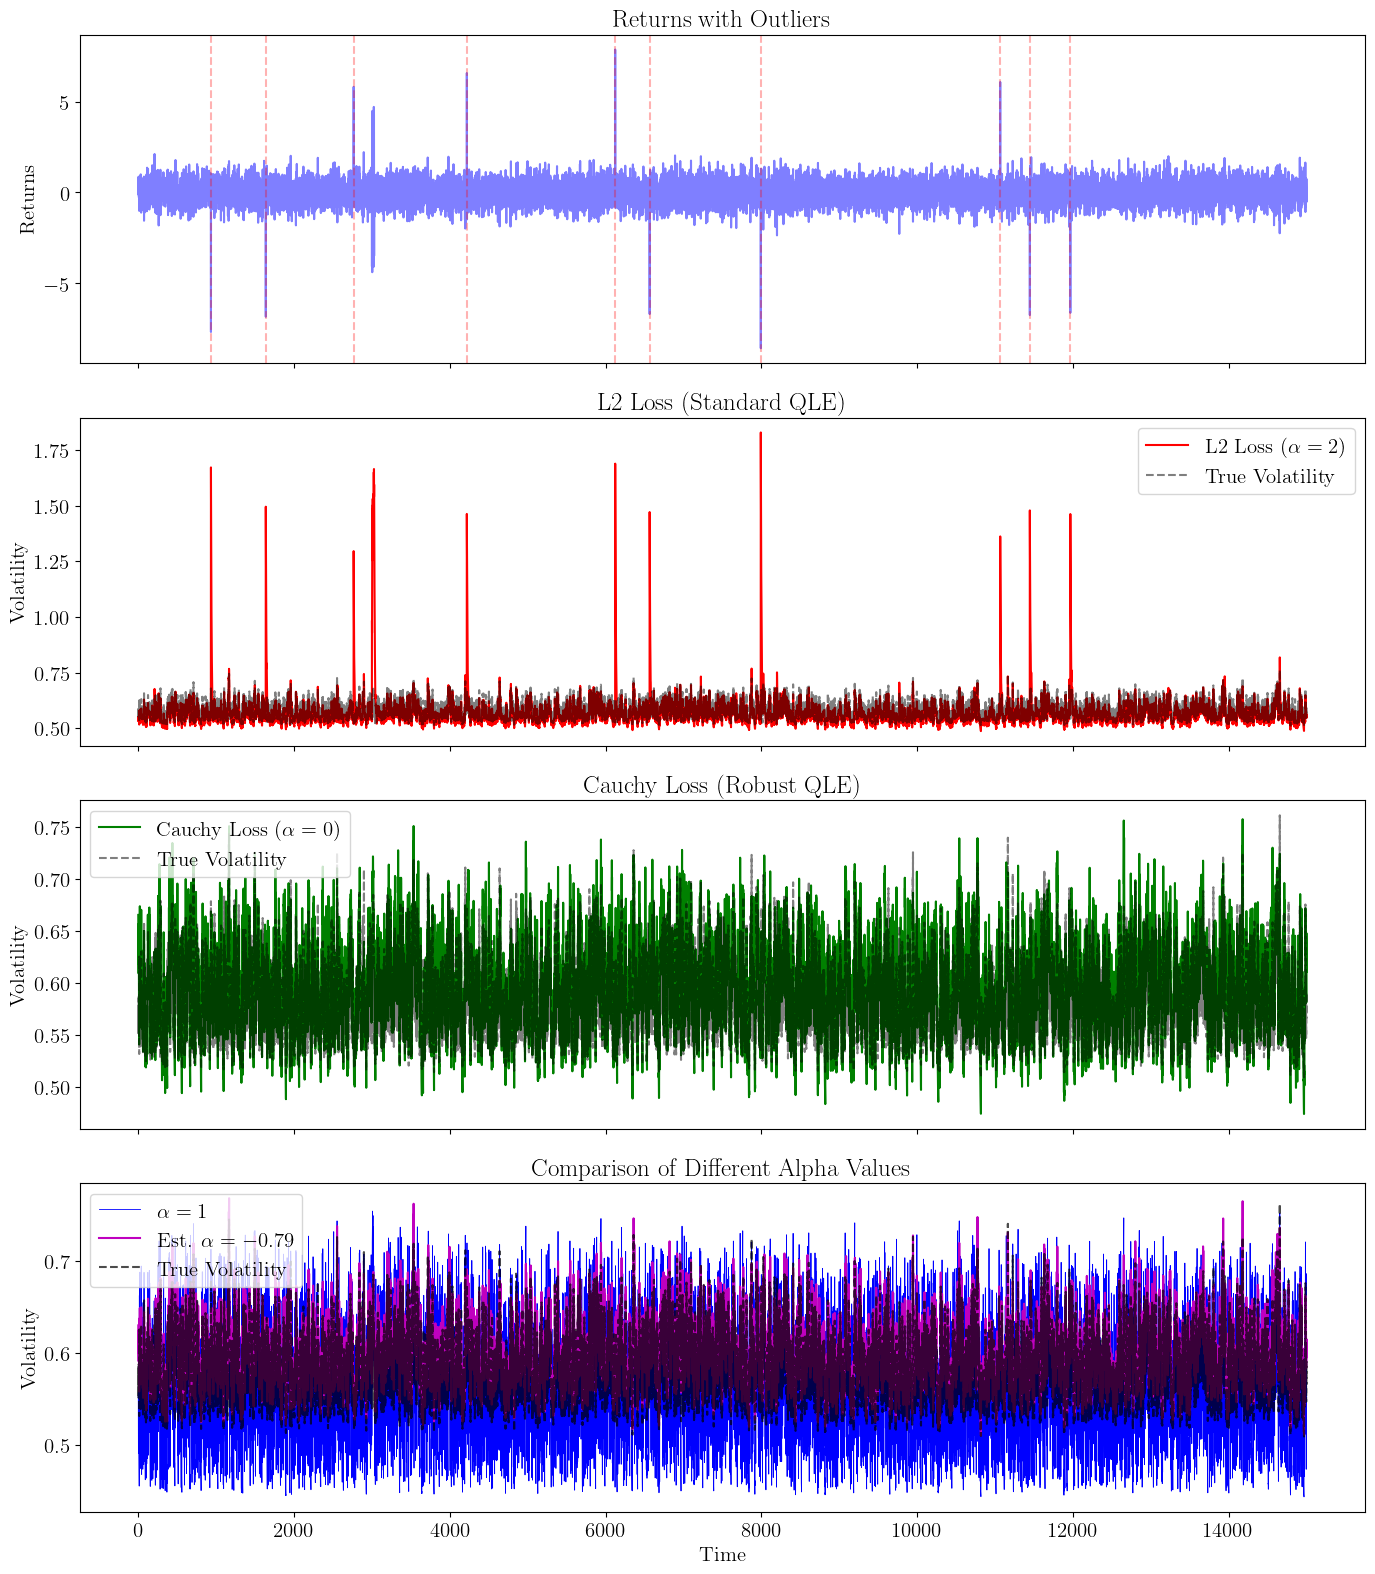

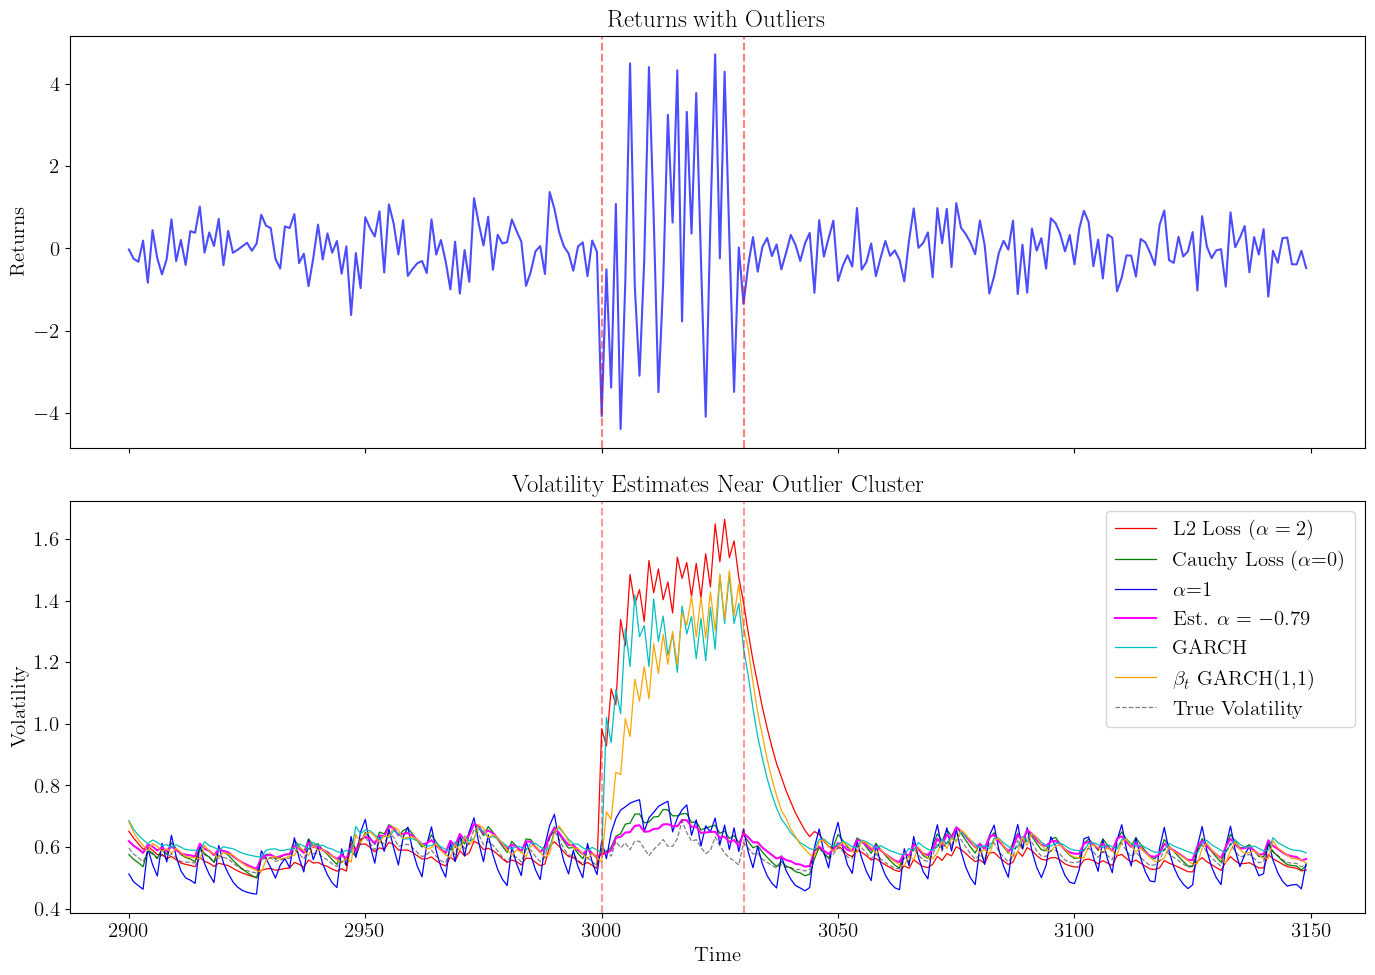

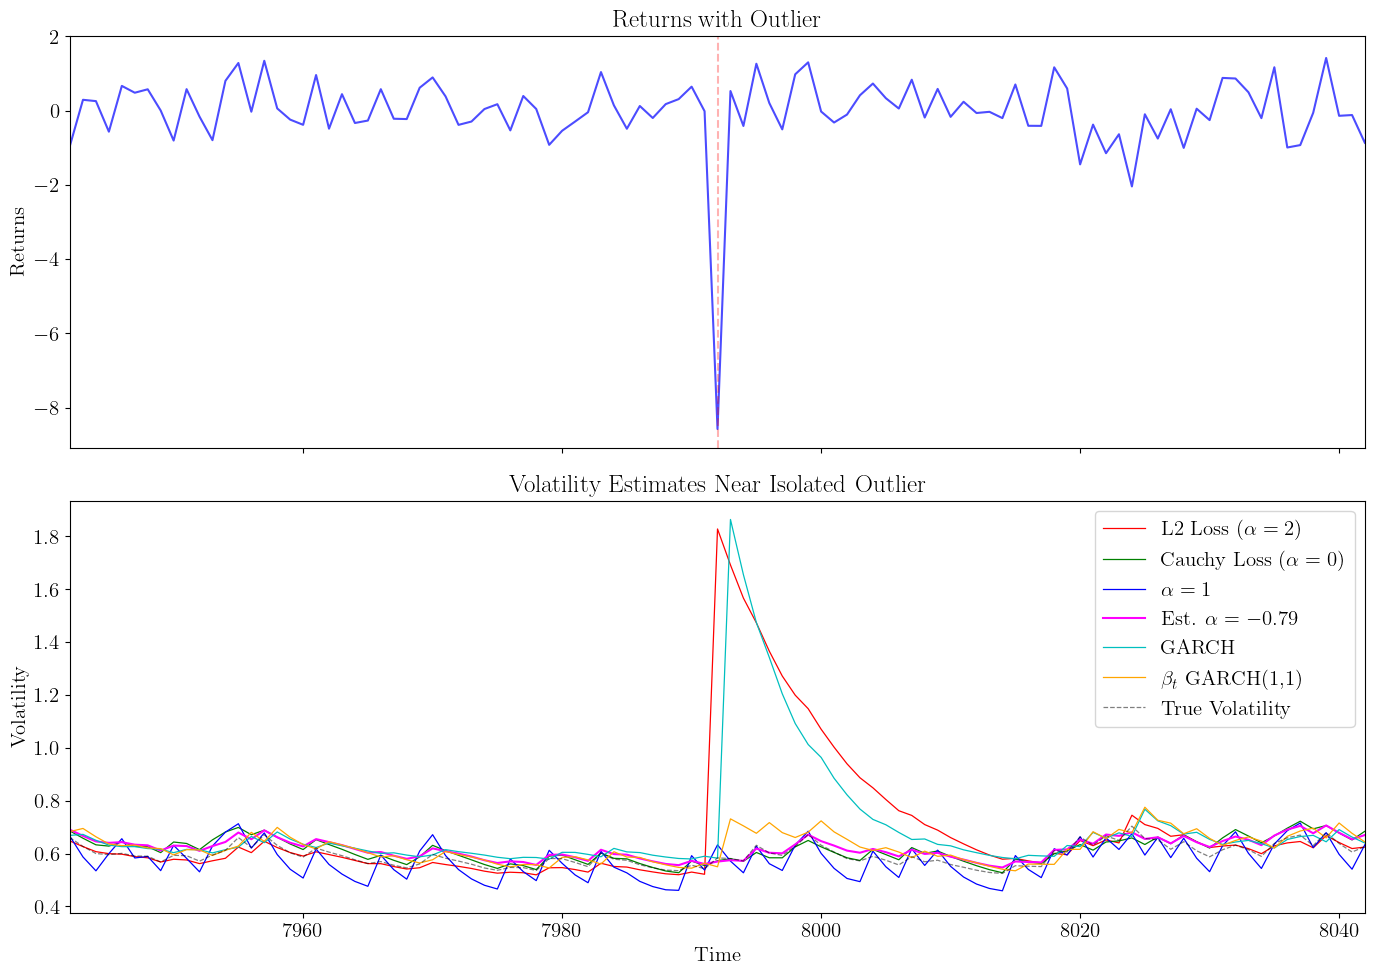


RMSE Comparison:
L2 Loss ($\alpha$=2): {rmse_l2:.6f}
Alpha=1.5: 0.153834
Cauchy Loss ($\alpha=0$): 0.035144
Alpha=1: 0.051743
Estimated Alpha ($\alpha$=-0.79): 0.030612
GAS Model: 0.115395
Beta-t GARCH(1,1): 0.069912

MAE Near Outliers:
L2 Loss ($\alpha=2$): 0.937235
Cauchy Loss ($\alpha=0$): 0.042556
Alpha=1: 0.058211
Estimated Alpha ($\alpha$=-0.79): 0.035362
GARCH: 0.742432
$\beta_t$ GARCH(1,1): 0.331799


In [11]:
import os
from matplotlib import rc
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':'15'})
rc('text', usetex=True)

# Compare volatility estimates
fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# Plot returns with outliers
axes[0].plot(y_outliers, 'b-', alpha=0.5)
axes[0].set_title('Returns with Outliers')
axes[0].set_ylabel('Returns')

# Highlight outlier positions
for pos in outlier_positions:
    axes[0].axvline(x=pos, color='r', linestyle='--', alpha=0.3)
#axes[0].axvspan(cluster_start, cluster_start + 30, color='r', alpha=0.1)

# Plot estimated volatilities
axes[1].plot(np.sqrt(model_l2.fitted_volatility), 'r-', label=rf"L2 Loss ($\alpha=2$)")
axes[1].plot(np.sqrt(true_vol), 'k--', alpha=0.5, label='True Volatility')
axes[1].set_title('L2 Loss (Standard QLE)')
axes[1].set_ylabel('Volatility')
axes[1].legend()

axes[2].plot(np.sqrt(model_cauchy.fitted_volatility), 'g-', label=rf'Cauchy Loss ($\alpha=0$)')
axes[2].plot(np.sqrt(true_vol), 'k--', alpha=0.5, label='True Volatility')
axes[2].set_title('Cauchy Loss (Robust QLE)')
axes[2].set_ylabel('Volatility')
axes[2].legend()

axes[3].plot(np.sqrt(model_alpha1.fitted_volatility), 'b-', label=r'$\alpha=1$', linewidth=0.6)
axes[3].plot(np.sqrt(model_est.fitted_volatility), 'm-', label=rf'Est. $\alpha={params_est["alpha_loss"]:.2f}$')
axes[3].plot(np.sqrt(true_vol), 'k--', alpha=0.7, label='True Volatility')
axes[3].set_title('Comparison of Different Alpha Values')
axes[3].set_ylabel('Volatility')
axes[3].set_xlabel('Time')
axes[3].legend()

plt.tight_layout()
plt.show()

#Zoom in on outlier cluster region
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

window_start = cluster_start - 100
window_end = cluster_start + 150

# Plot returns with outliers (zoomed)
axes[0].plot(range(window_start, window_end), y_outliers[window_start:window_end], 'b-', alpha=0.7)
axes[0].set_title('Returns with Outliers')
axes[0].set_ylabel('Returns')
#axes[0].axvspan(cluster_start, cluster_start + 30, color='grey', alpha=0.05)  # highlight cluster region
axes[0].axvline(x=cluster_start, color='r', linestyle='--', alpha=0.5)
axes[0].axvline(x=cluster_start + 30, color='r', linestyle='--', alpha=0.5)

# Plot estimated volatilities (zoomed)
axes[1].plot(range(window_start, window_end), np.sqrt(model_l2.fitted_volatility[window_start:window_end]), 
                'r-', label=rf"L2 Loss ($\alpha=2$)", linewidth=0.9)
axes[1].plot(range(window_start, window_end), np.sqrt(model_cauchy.fitted_volatility[window_start:window_end]), 
                'g-', label=rf'Cauchy Loss ($\alpha$=0)', linewidth=0.9)
# axes[1].plot(range(window_start, window_end), np.sqrt(model_alpha1_5.fitted_volatility[window_start:window_end]),
#                 '-', label='α=1.5', linewidth=0.9)
axes[1].plot(range(window_start, window_end), np.sqrt(model_alpha1.fitted_volatility[window_start:window_end]), 
                'b-', label=rf'$\alpha$=1', linewidth=0.9)
axes[1].plot(range(window_start, window_end), np.sqrt(model_est.fitted_volatility[window_start:window_end]), 
                color='magenta', label=rf'Est. $\alpha={params_est["alpha_loss"]:.2f}$')
axes[1].plot(range(window_start, window_end), np.sqrt(gas_model.get_fitted_variance()[window_start:window_end]),
                'c-', label='GARCH', linewidth=0.9)
axes[1].plot(range(window_start, window_end), np.sqrt(beta_t.fitted_f[window_start:window_end]),
                'orange', label=rf'$\beta_t$ GARCH(1,1)', linewidth=0.9)
axes[1].plot(range(window_start, window_end), np.sqrt(true_vol[window_start:window_end]), 
                'k--', alpha=0.5, label='True Volatility', linewidth=0.9)
#axes[1].axvspan(cluster_start, cluster_start + 30, color='grey', alpha=0.05)  # highlight cluster region
axes[1].axvline(x=cluster_start, color='r', linestyle='--', alpha=0.4)
axes[1].axvline(x=cluster_start + 30, color='r', linestyle='--', alpha=0.4)


axes[1].set_title('Volatility Estimates Near Outlier Cluster')
axes[1].set_ylabel('Volatility')
axes[1].set_xlabel('Time')
axes[1].legend()

plt.tight_layout()
plt.savefig("zoomed_outlier_cluster.pdf", format="pdf")
plt.show()

# zoom in on isolated outliers
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
window_start = outlier_positions[0] - 100
window_end = outlier_positions[0] + 100
# Plot returns with outliers (zoomed)
axes[0].plot(range(window_start, window_end), y_outliers[window_start:window_end], 'b-', alpha=0.7)
axes[0].set_title('Returns with Outlier')
axes[0].set_ylabel('Returns')
# Highlight outlier positions
for pos in outlier_positions:
    axes[0].axvline(x=pos, color='r', linestyle='--', alpha=0.3)
# Plot estimated volatilities (zoomed)
axes[1].plot(range(window_start, window_end), np.sqrt(model_l2.fitted_volatility[window_start:window_end]),
                'r-', label=r"L2 Loss ($\alpha=2$)", linewidth=0.9)
axes[1].plot(range(window_start, window_end), np.sqrt(model_cauchy.fitted_volatility[window_start:window_end]),
                'g-', label=r'Cauchy Loss ($\alpha=0$)', linewidth=0.9)
axes[1].plot(range(window_start, window_end), np.sqrt(model_alpha1.fitted_volatility[window_start:window_end]),
                'b-', label=r'$\alpha=1$', linewidth=0.9)
axes[1].plot(range(window_start, window_end), np.sqrt(model_est.fitted_volatility[window_start:window_end]),
                color='magenta', label=rf'Est. $\alpha={params_est["alpha_loss"]:.2f}$')
axes[1].plot(range(window_start, window_end), np.sqrt(gas_model.get_fitted_variance()[window_start:window_end]),
                'c-', label='GARCH', linewidth=0.9)
axes[1].plot(range(window_start, window_end), np.sqrt(beta_t.fitted_f[window_start:window_end]),
                'orange', label=rf'$\beta_t$ GARCH(1,1)', linewidth=0.9)
axes[1].plot(range(window_start, window_end), np.sqrt(true_vol[window_start:window_end]),
                'k--', alpha=0.5, label='True Volatility', linewidth=0.9)

axes[1].set_title('Volatility Estimates Near Isolated Outlier')
axes[1].set_ylabel('Volatility')
axes[1].set_xlabel('Time')
axes[1].legend()
axes[1].set_xlim(window_start+50, window_end-50)
plt.tight_layout()
plt.savefig("volatility_comparison.pdf", format="pdf")
plt.show()  

# Calculate RMSE for each model
rmse_l2 = np.sqrt(np.mean((model_l2.fitted_volatility - true_vol)**2))
rmse_alpha1_5 = np.sqrt(np.mean((model_alpha1_5.fitted_volatility - true_vol)**2))
rmse_cauchy = np.sqrt(np.mean((model_cauchy.fitted_volatility - true_vol)**2))
rmse_alpha1 = np.sqrt(np.mean((model_alpha1.fitted_volatility - true_vol)**2))
rmse_est = np.sqrt(np.mean((model_est.fitted_volatility - true_vol)**2))
rmse_gas = np.sqrt(np.mean((gas_model.get_fitted_variance() - true_vol)**2))
rmse_beta_t = np.sqrt(np.mean((beta_t.fitted_f - true_vol)**2))

print("\nRMSE Comparison:")
print(r"L2 Loss ($\alpha$=2): {rmse_l2:.6f}")
print(f"Alpha=1.5: {rmse_alpha1_5:.6f}")
print(f"Cauchy Loss ($\\alpha=0$): {rmse_cauchy:.6f}")
print(f"Alpha=1: {rmse_alpha1:.6f}")
print(f"Estimated Alpha ($\\alpha$={params_est['alpha_loss']:.2f}): {rmse_est:.6f}")
print(f"GAS Model: {rmse_gas:.6f}")
print(f"Beta-t GARCH(1,1): {rmse_beta_t:.6f}")

# Calculate mean absolute error near outliers
near_outliers = np.zeros(T, dtype=bool)
for pos in outlier_positions:
    # Mark 5 observations before and after each outlier
    start = max(0, pos-5)
    end = min(T, pos+6)
    near_outliers[start:end] = True

# Also mark the cluster region
near_outliers[cluster_start:cluster_start+40] = True

# Calculate MAE near outliers
mae_l2_near = np.mean(np.abs(model_l2.fitted_volatility[near_outliers] - true_vol[near_outliers]))

mae_cauchy_near = np.mean(np.abs(model_cauchy.fitted_volatility[near_outliers] - true_vol[near_outliers]))
mae_alpha1_near = np.mean(np.abs(model_alpha1.fitted_volatility[near_outliers] - true_vol[near_outliers]))
mae_est_near = np.mean(np.abs(model_est.fitted_volatility[near_outliers] - true_vol[near_outliers]))
mae_gas_near = np.mean(np.abs(gas_model.get_fitted_variance()[near_outliers] - true_vol[near_outliers]))
mae_beta_t_near = np.mean(np.abs(beta_t.fitted_f[near_outliers] - true_vol[near_outliers]))

print("\nMAE Near Outliers:")
print(f"L2 Loss ($\\alpha=2$): {mae_l2_near:.6f}")
print(f"Cauchy Loss ($\\alpha=0$): {mae_cauchy_near:.6f}")
print(f"Alpha=1: {mae_alpha1_near:.6f}")
print(f"Estimated Alpha ($\\alpha$={params_est['alpha_loss']:.2f}): {mae_est_near:.6f}")
print(f"GARCH: {mae_gas_near:.6f}")
print(r'$\beta_t$ GARCH(1,1)'f": {mae_beta_t_near:.6f}")
